In [ ]:
# Fix lỗi TensorBoard và protobuf trên Colab
!pip install --upgrade protobuf tensorboard -q

# ArcFace Evaluation - Kaggle (Fixed)

**FIX**: Dung embedding-based classification thay vi logits-based

## Van de truoc do:
- ArcFace model can labels de tinh logits (ArcMarginProduct)
- Label mapping khac nhau giua train va eval datasets
- Ket qua: accuracy gan 0%

## Fix:
- Extract embeddings cho train set (prototypes)
- Extract embeddings cho eval set
- Classification bang cosine similarity

In [32]:
# # Fix numpy/matplotlib conflict - CHAY CELL NAY TRUOC
# !pip install -q "numpy<2.0" --force-reinstall
# # SAU DO RESTART KERNEL: Runtime > Restart runtime

In [33]:
import os, sys, time, json
import shutil, glob
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

ROOT = "/kaggle/working/FaceRecognition"
CHECKPOINT_DIR = "/kaggle/working/checkpoints/arcface"
KAGGLE_DATASET_NAME = "celeba-aligned-balanced"
DATA_DIR = f"/kaggle/input/{KAGGLE_DATASET_NAME}"
CHECKPOINT_DATASET_NAME = "arcface-checkpoints"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [34]:
# Copy checkpoint
checkpoint_input = f"/kaggle/input/{CHECKPOINT_DATASET_NAME}"
if os.path.exists(checkpoint_input):
    for pth in glob.glob(os.path.join(checkpoint_input, "**/*.pth"), recursive=True):
        dest = os.path.join(CHECKPOINT_DIR, os.path.basename(pth))
        if not os.path.exists(dest): shutil.copy(pth, dest)
    print(f"Checkpoints: {os.listdir(CHECKPOINT_DIR)}")

Checkpoints: ['arcface_best.pth']


In [35]:
# Cau hinh GitHub token (neu repository la private hoac can authentication)
# 
# HUONG DAN:
# 1. Vao: https://github.com/settings/tokens
# 2. Click "Generate new token" > "Generate new token (classic)"
# 3. Chon quyen: "repo" (neu PRIVATE) hoac "public_repo" (neu PUBLIC)
# 4. Copy token
# 5. Vao Kaggle notebook: Settings > Add-ons > Secrets
# 6. Them secret: name="GITHUB_TOKEN", value="your_token_here"

# Lay token tu Kaggle Secrets (an toan, khong lo token)
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    GITHUB_TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
    print("[OK] Da lay GITHUB_TOKEN tu Kaggle Secrets")
except Exception as e:
    GITHUB_TOKEN = None
    print("[WARN] Khong lay duoc token tu Kaggle Secrets")
    print(f"       Loi: {e}")
    print("       Neu repo la private, hay them secret 'GITHUB_TOKEN' trong Settings > Secrets")

if GITHUB_TOKEN:
    REPO_URL = f"https://{GITHUB_TOKEN}@github.com/sin0235/FaceRecognition.git"
    print("     Repository: https://[TOKEN]@github.com/sin0235/FaceRecognition.git")
else:
    REPO_URL = "https://github.com/sin0235/FaceRecognition.git"
    print("[INFO] Su dung public URL (khong can token)")


[OK] Da lay GITHUB_TOKEN tu Kaggle Secrets
     Repository: https://[TOKEN]@github.com/sin0235/FaceRecognition.git


In [36]:
# Clone repository tu GitHub

if os.path.exists(ROOT):
    print("Repository da ton tai, dang pull updates...")
    %cd {ROOT}
    if GITHUB_TOKEN:
        !git remote set-url origin {REPO_URL}
    !git pull
else:
    print(f"Dang clone repository...")
    !git clone {REPO_URL} {ROOT}
    %cd {ROOT}

print(f"\nWorking directory: {os.getcwd()}")
!ls -la

Repository da ton tai, dang pull updates...
/kaggle/working/FaceRecognition
Already up to date.

Working directory: /kaggle/working/FaceRecognition
total 112
drwxr-xr-x 16 root root  4096 Dec 14 03:28 .
drwxr-xr-x  5 root root  4096 Dec 14 03:34 ..
drwxr-xr-x  2 root root  4096 Dec 14 03:28 app
drwxr-xr-x  2 root root  4096 Dec 14 03:28 configs
drwxr-xr-x  8 root root  4096 Dec 14 03:49 .git
drwxr-xr-x  3 root root  4096 Dec 14 03:28 .github
-rw-r--r--  1 root root  1222 Dec 14 03:28 .gitignore
drwxr-xr-x  2 root root  4096 Dec 14 03:28 inference
-rw-r--r--  1 root root  1075 Dec 14 03:28 LICENSE
drwxr-xr-x  3 root root  4096 Dec 14 03:28 logs
drwxr-xr-x  5 root root  4096 Dec 14 03:28 models
drwxr-xr-x  2 root root  4096 Dec 14 03:28 notebooks
drwxr-xr-x  2 root root  4096 Dec 14 03:28 preprocessing
-rw-r--r--  1 root root    59 Dec 14 03:28 README.md
-rw-r--r--  1 root root   511 Dec 14 03:28 requirements-colab.txt
-rw-r--r--  1 root root   483 Dec 14 03:28 requirements-local.txt
-rw

In [37]:
!pip install -q opencv-python-headless Pillow scikit-learn tqdm pyyaml matplotlib seaborn

In [38]:
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


---
## 1. Load Model

In [39]:
from models.arcface.arcface_model import ArcFaceModel

checkpoint_path = os.path.join(CHECKPOINT_DIR, "arcface_best.pth")
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
num_classes = checkpoint.get('num_classes', 9343)

model = ArcFaceModel(num_classes=num_classes, pretrained=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

print(f"Model: {num_classes} classes")
print(f"Training epochs: {checkpoint.get('epoch', 0) + 1}")
print(f"Best val acc (training): {checkpoint.get('best_val_acc', 0):.2f}%")

Model: 9343 classes
Training epochs: 105
Best val acc (training): 81.53%


---
## 2. Build Reference Database (Train Set Prototypes)

In [40]:
from models.arcface.arcface_dataloader import get_val_transforms
from torch.utils.data import DataLoader, Dataset

# Tim data dirs
train_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "train")
val_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "val")
test_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "test")

if not os.path.exists(train_dir):
    train_dir = os.path.join(DATA_DIR, "train")
    val_dir = os.path.join(DATA_DIR, "val")
    test_dir = os.path.join(DATA_DIR, "test")

print(f"Train dir: {train_dir}")
print(f"Val dir: {val_dir}")
print(f"Test dir: {test_dir}")

Train dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/train
Val dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/val
Test dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/test


In [41]:
# Dataset class don gian
class SimpleDataset(Dataset):
    def __init__(self, data_root, transform, max_per_identity=None):
        self.transform = transform
        self.samples = []  # (path, identity_name)
        
        for identity in sorted(os.listdir(data_root)):
            identity_path = os.path.join(data_root, identity)
            if not os.path.isdir(identity_path): continue
            
            imgs = [f for f in os.listdir(identity_path) if f.lower().endswith(('.jpg', '.png'))]
            if max_per_identity:
                imgs = imgs[:max_per_identity]
            
            for img in imgs:
                self.samples.append((os.path.join(identity_path, img), identity))
    
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        path, identity = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, identity

In [42]:
# Extract embeddings cho train set (prototypes)
transform = get_val_transforms(image_size=112)
train_dataset = SimpleDataset(train_dir, transform, max_per_identity=5)  # Max 5 anh/identity de nhanh
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")

# Extract embeddings
identity_embeddings = defaultdict(list)

print("Extracting train embeddings...")
with torch.no_grad():
    for images, identities in tqdm(train_loader):
        images = images.to(device)
        embeddings = model.extract_features(images)  # [B, 512]
        embeddings = embeddings.cpu().numpy()
        
        for emb, identity in zip(embeddings, identities):
            identity_embeddings[identity].append(emb)

# Tinh prototype (mean embedding) cho moi identity
prototypes = {}
for identity, embs in identity_embeddings.items():
    mean_emb = np.mean(embs, axis=0)
    mean_emb = mean_emb / np.linalg.norm(mean_emb)  # L2 normalize
    prototypes[identity] = mean_emb

print(f"Built {len(prototypes)} identity prototypes")

Train samples: 46715
Extracting train embeddings...


100%|██████████| 365/365 [00:29<00:00, 12.36it/s]


Built 9343 identity prototypes


In [43]:
# Chuyen prototypes thanh matrix de tinh nhanh
identity_list = sorted(prototypes.keys())
identity_to_idx = {name: i for i, name in enumerate(identity_list)}
prototype_matrix = np.array([prototypes[name] for name in identity_list])  # [N, 512]

print(f"Prototype matrix: {prototype_matrix.shape}")

Prototype matrix: (9343, 512)


---
## 3. Evaluate with Embedding-based Classification

In [44]:
# Load eval dataset (val hoac test)
eval_dir = test_dir if os.path.exists(test_dir) else val_dir
eval_dataset = SimpleDataset(eval_dir, transform)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False, num_workers=4)

print(f"Eval dir: {eval_dir}")
print(f"Eval samples: {len(eval_dataset)}")

Eval dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/test
Eval samples: 20387


In [45]:
# Evaluate bang cosine similarity
all_true_labels = []  # index trong identity_list
all_pred_labels = []
all_similarities = []

print("Evaluating with cosine similarity...")
with torch.no_grad():
    for images, identities in tqdm(eval_loader):
        images = images.to(device)
        embeddings = model.extract_features(images).cpu().numpy()  # [B, 512]
        
        # Cosine similarity voi tat ca prototypes
        # embeddings: [B, 512], prototype_matrix: [N, 512]
        similarities = np.dot(embeddings, prototype_matrix.T)  # [B, N]
        
        # Top-1 predictions
        pred_indices = np.argmax(similarities, axis=1)
        
        for identity, pred_idx, sim_row in zip(identities, pred_indices, similarities):
            true_idx = identity_to_idx.get(identity, -1)
            if true_idx >= 0:
                all_true_labels.append(true_idx)
                all_pred_labels.append(pred_idx)
                all_similarities.append(sim_row)

all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)
all_similarities = np.array(all_similarities)

Evaluating with cosine similarity...


100%|██████████| 160/160 [00:20<00:00,  7.71it/s]


In [46]:
# Tinh metrics
# Top-1 Accuracy
top1_acc = (all_pred_labels == all_true_labels).mean() * 100

# Top-5 Accuracy
top5_preds = np.argsort(all_similarities, axis=1)[:, -5:]
top5_correct = [t in p for t, p in zip(all_true_labels, top5_preds)]
top5_acc = np.mean(top5_correct) * 100

print(f"\n{'='*50}")
print(f"EVALUATION RESULTS (Embedding-based)")
print(f"{'='*50}")
print(f"Total samples: {len(all_true_labels)}")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


EVALUATION RESULTS (Embedding-based)
Total samples: 20387
Top-1 Accuracy: 88.14%
Top-5 Accuracy: 94.11%


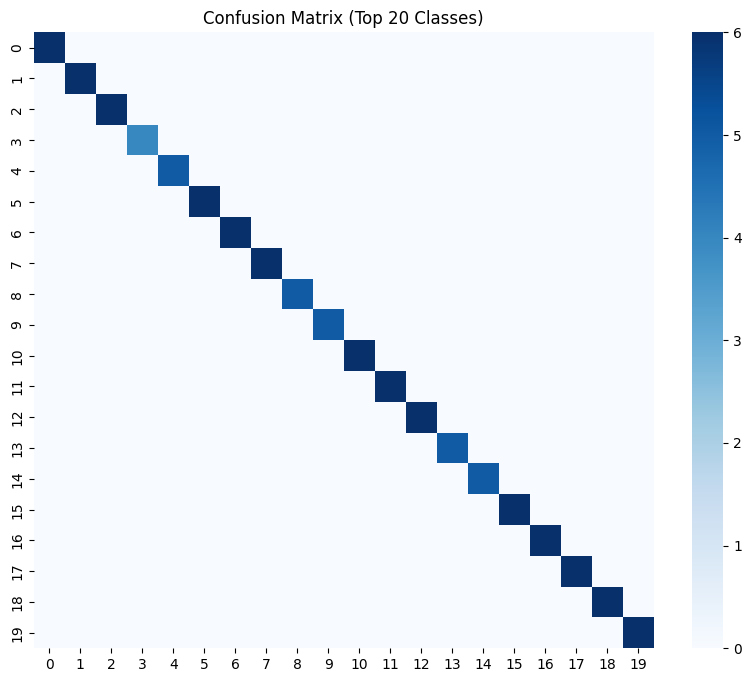

In [47]:
# Confusion Matrix (top 20 classes)
sample_classes = 20
class_counts = np.bincount(all_true_labels, minlength=len(identity_list))
top_classes = np.argsort(class_counts)[-sample_classes:]
mask = np.isin(all_true_labels, top_classes)

labels_sub = all_true_labels[mask]
preds_sub = all_pred_labels[mask]

# Remap
label_map = {old: new for new, old in enumerate(sorted(set(labels_sub)))}
labels_re = np.array([label_map.get(l, -1) for l in labels_sub])
preds_re = np.array([label_map.get(p, -1) for p in preds_sub])
valid = (labels_re >= 0) & (preds_re >= 0)

cm = confusion_matrix(labels_re[valid], preds_re[valid])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues')
plt.title(f'Confusion Matrix (Top {sample_classes} Classes)')
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=150)
plt.show()

Computing ROC Curve...


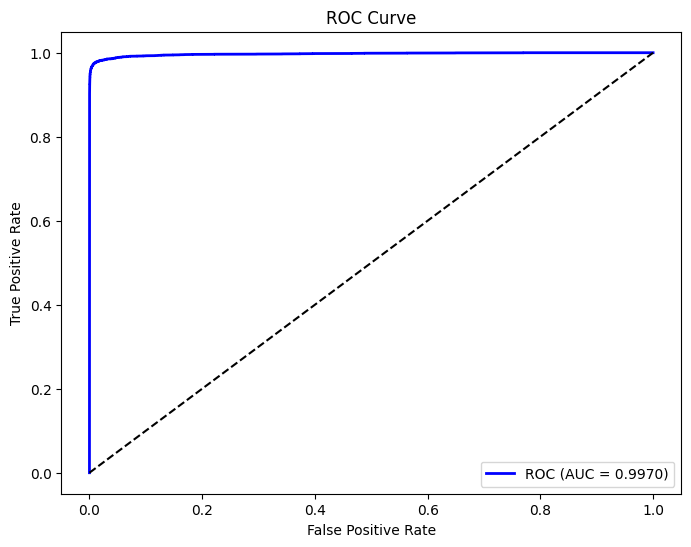

AUC: 0.9970


In [48]:
# ROC Curve / AUC
print("Computing ROC Curve...")

# Sample
sample_size = min(5000, len(all_true_labels))
idx = np.random.choice(len(all_true_labels), sample_size, replace=False)
labels_sample = all_true_labels[idx]
sims_sample = all_similarities[idx]

classes = np.unique(labels_sample)
y_true_bin = label_binarize(labels_sample, classes=classes)
sims_for_classes = sims_sample[:, classes]

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), sims_for_classes.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('/kaggle/working/roc_curve.png', dpi=150)
plt.show()

print(f"AUC: {roc_auc:.4f}")

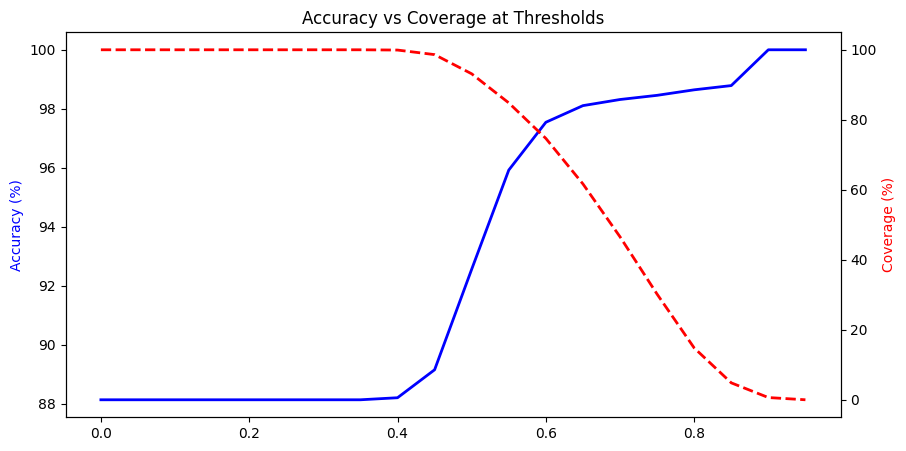

In [49]:
# Threshold Analysis
max_sims = np.max(all_similarities, axis=1)
is_correct = (all_pred_labels == all_true_labels).astype(int)

thresholds = np.arange(0.0, 1.0, 0.05)
accs, covs = [], []
for t in thresholds:
    m = max_sims >= t
    covs.append(m.mean() * 100)
    accs.append(is_correct[m].mean() * 100 if m.sum() > 0 else 0)

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(thresholds, accs, 'b-', lw=2, label='Accuracy')
ax1.set_ylabel('Accuracy (%)', color='blue')
ax2 = ax1.twinx()
ax2.plot(thresholds, covs, 'r--', lw=2, label='Coverage')
ax2.set_ylabel('Coverage (%)', color='red')
plt.title('Accuracy vs Coverage at Thresholds')
plt.savefig('/kaggle/working/threshold_analysis.png', dpi=150)
plt.show()

---
## 4. Performance Tests

In [50]:
# Latency Test
dummy = torch.randn(1, 3, 112, 112).to(device)
for _ in range(10): model.extract_features(dummy)

latencies = []
for _ in range(100):
    if device == 'cuda': torch.cuda.synchronize()
    start = time.time()
    model.extract_features(torch.randn(1, 3, 112, 112).to(device))
    if device == 'cuda': torch.cuda.synchronize()
    latencies.append((time.time() - start) * 1000)

print(f"Latency: {np.mean(latencies):.2f} ms (avg)")

Latency: 7.89 ms (avg)


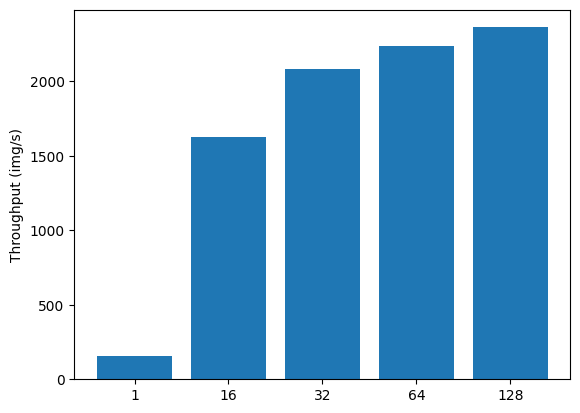

In [51]:
# Throughput Test
batch_sizes = [1, 16, 32, 64, 128]
throughputs = []
for bs in batch_sizes:
    dummy = torch.randn(bs, 3, 112, 112).to(device)
    for _ in range(5): model.extract_features(dummy)
    if device == 'cuda': torch.cuda.synchronize()
    start = time.time()
    for _ in range(20): model.extract_features(dummy)
    if device == 'cuda': torch.cuda.synchronize()
    throughputs.append((bs * 20) / (time.time() - start))

plt.bar([str(b) for b in batch_sizes], throughputs)
plt.ylabel('Throughput (img/s)')
plt.savefig('/kaggle/working/throughput.png', dpi=150)
plt.show()

---
## 5. t-SNE Visualization

 10%|█         | 16/160 [00:01<00:16,  8.58it/s]


t-SNE samples: 208


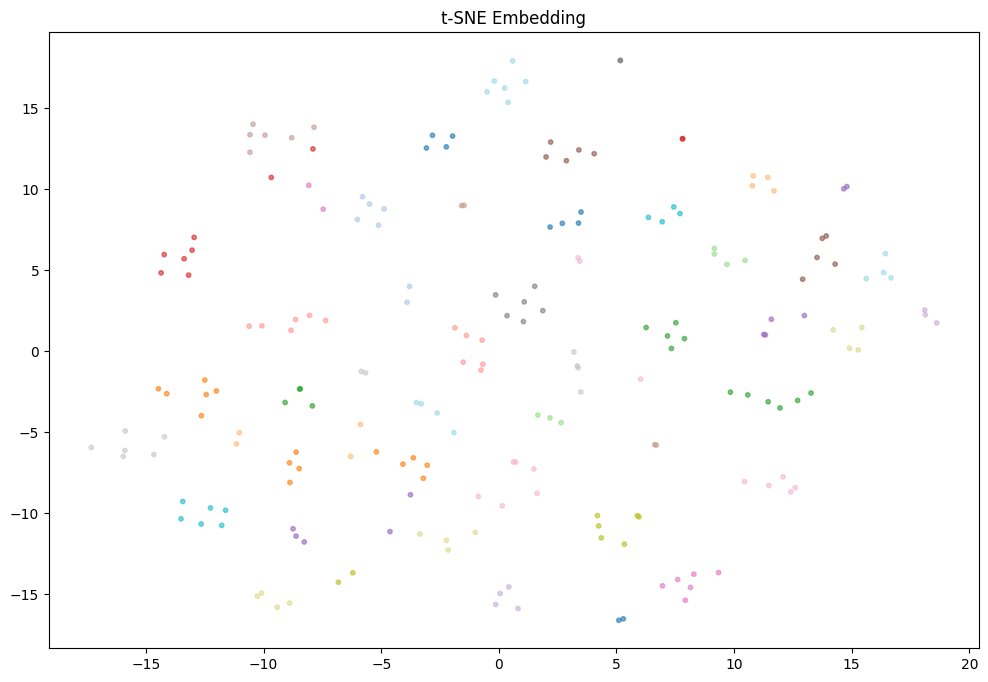

In [55]:
# Extract eval embeddings for t-SNE
!pip install numpy
emb_list, lbl_list = [], []
with torch.no_grad():
    for img, identity in tqdm(eval_loader):
        if len(emb_list) * 128 >= 2000: break
        emb_list.append(model.extract_features(img.to(device)).cpu().numpy())
        lbl_list.extend([identity_to_idx.get(i, -1) for i in identity])

embs = np.concatenate(emb_list)[:2000]
lbls = np.array(lbl_list)[:2000]
valid = lbls >= 0
embs, lbls = embs[valid], lbls[valid]

# Top 50 classes
uniq = np.unique(lbls)[:50]
mask = np.isin(lbls, uniq)
embs, lbls = embs[mask], lbls[mask]

print(f"t-SNE samples: {len(embs)}")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embs_2d = tsne.fit_transform(embs)

plt.figure(figsize=(12, 8))
plt.scatter(embs_2d[:, 0], embs_2d[:, 1], c=lbls, cmap='tab20', s=10, alpha=0.6)
plt.title('t-SNE Embedding')
plt.savefig('/kaggle/working/tsne.png', dpi=150)
plt.show()

---
## 6. Final Report

In [53]:
report = {
    'timestamp': datetime.now().isoformat(),
    'method': 'embedding-based (cosine similarity)',
    'model': {
        'num_classes': int(num_classes),
        'epochs': int(checkpoint.get('epoch', 0) + 1),
        'training_val_acc': float(checkpoint.get('best_val_acc', 0))
    },
    'metrics': {
        'top1_accuracy': float(top1_acc),
        'top5_accuracy': float(top5_acc),
        'auc': float(roc_auc)
    },
    'performance': {
        'avg_latency_ms': float(np.mean(latencies)),
        'max_throughput': float(max(throughputs))
    }
}

with open('/kaggle/working/evaluation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*50)
print("FINAL EVALUATION REPORT")
print("="*50)
print(f"Method: Embedding-based (cosine similarity)")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")
print(f"AUC: {roc_auc:.4f}")
print(f"Avg Latency: {np.mean(latencies):.2f} ms")


FINAL EVALUATION REPORT
Method: Embedding-based (cosine similarity)
Top-1 Accuracy: 88.14%
Top-5 Accuracy: 94.11%
AUC: 0.9970
Avg Latency: 7.89 ms


In [54]:
!ls -la /kaggle/working/*.png /kaggle/working/*.json

-rw-r--r-- 1 root root 43029 Dec 14 03:50 /kaggle/working/confusion_matrix.png
-rw-r--r-- 1 root root   438 Dec 14 03:51 /kaggle/working/evaluation_report.json
-rw-r--r-- 1 root root 49662 Dec 14 03:50 /kaggle/working/roc_curve.png
-rw-r--r-- 1 root root 57328 Dec 14 03:50 /kaggle/working/threshold_analysis.png
-rw-r--r-- 1 root root 19520 Dec 14 03:51 /kaggle/working/throughput.png
-rw-r--r-- 1 root root 80647 Dec 14 03:51 /kaggle/working/tsne.png


In [56]:
# Zip tat ca outputs de tai ve
import zipfile
import os

output_dir = "/kaggle/working"
zip_path = "/kaggle/working/evaluation_results.zip"

# Tao file zip
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename in os.listdir(output_dir):
        filepath = os.path.join(output_dir, filename)
        if filename.endswith(('.png', '.json', '.csv')):
            zipf.write(filepath, filename)
            print(f"Added: {filename}")

print(f"\nZip file: {zip_path}")
print(f"Size: {os.path.getsize(zip_path) / 1024:.1f} KB")

# Tao link tai ve
from IPython.display import FileLink
FileLink(zip_path)

Added: threshold_analysis.png
Added: evaluation_report.json
Added: roc_curve.png
Added: tsne.png
Added: throughput.png
Added: confusion_matrix.png

Zip file: /kaggle/working/evaluation_results.zip
Size: 205.4 KB


/kaggle/working/evaluation_results.zip